In [ ]:
import tensorflow
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import os
from IPython.display import Audio


In [ ]:
try:
  import mido
  print("mido is installed.")
except ImportError:
  print("mido is not installed. Installing now...")
  !pip install mido
  !apt install fluidsynth
  !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
  import mido
  print("mido, fluidsynth installed successfully.")


In [ ]:
def quartet_to_midi(chorale, midi_file, tempo=120):
		"""Convert a CSV file from the JSB Chorales dataset to MIDI."""
		# Create a new MIDI file with a single track
		mid = MidiFile()
		track = MidiTrack()
		mid.tracks.append(track)

		# Set tempo (500000 microseconds per beat = 120 BPM)
		tempo_value = 500000  # in microseconds per beat
		track.append(Message('program_change', program=0, time=0))  # Piano

		# Each row in the array represents a time step (e.g., a 16th note)
		# Each column represents a voice (soprano, alto, tenor, bass)
		# The values represent MIDI note numbers

		ticks_per_beat = mid.ticks_per_beat
		# Let's use 16th notes (1/4 of a beat)
		ticks_per_step = ticks_per_beat // 4

		# Process each time step
		active_notes = {}  # To keep track of currently playing notes

		velocity = 100
		prev_notes = [0,0,0,0]
		now = 0
		last_event = 0
		for step, notes in enumerate(chorale):
				# Process each voice
				for voice, note in enumerate(notes):
						note_id = (voice, note)

						# Convert to integer MIDI note number
						midi_note = int(note)
						if midi_note == prev_notes[voice]:
								pass
						else:
								track.append(Message('note_off', note=prev_notes[voice], velocity=0,
																time=now-last_event, channel=voice % 16))
								track.append(Message('note_on', note=midi_note, velocity=velocity,
																time=0, channel=voice % 16))
								last_event = now
						prev_notes[voice] = midi_note
				now = now + ticks_per_step

		# Save the MIDI file
		mid.save(midi_file)
		print(f"Saved MIDI file to {midi_file}")

In [ ]:
from mido import Message, MidiFile, MidiTrack

def array_to_midi(notes, midi_file, tempo=120):
		"""Convert a single note array to MIDI."""
		# Create a new MIDI file with a single track
		mid = MidiFile()
		track = MidiTrack()
		mid.tracks.append(track)

		# Set tempo (500000 microseconds per beat = 120 BPM)
		tempo_value = 500000  # in microseconds per beat
		track.append(Message('program_change', program=0, time=0))  # Piano

		# Each row in the CSV represents a time step (e.g., a 16th note)
		# Each column represents a voice (soprano, alto, tenor, bass)
		# The values represent MIDI note numbers

		ticks_per_beat = mid.ticks_per_beat
		# Let's use 16th notes (1/4 of a beat)
		ticks_per_step = ticks_per_beat // 4

		# Process each time step
		active_notes = {}  # To keep track of currently playing notes

		velocity = 100
		prev_note = 0
		now = 0
		last_event = 0
		voice = 0
		for note in notes[0]:
			note_id = (voice, note)

			# Convert to integer MIDI note number
			midi_note = int(note)
			if midi_note == prev_note:
				pass
			else:
				track.append(Message('note_off', note=prev_note, velocity=0,
												time=now-last_event, channel=voice % 16))
				track.append(Message('note_on', note=midi_note, velocity=velocity,
												time=0, channel=voice % 16))
				last_event = now
			prev_note = midi_note
			now = now + ticks_per_step

		# Save the MIDI file
		mid.save(midi_file)
		print(f"Saved MIDI file to {midi_file}")


# Preprocess

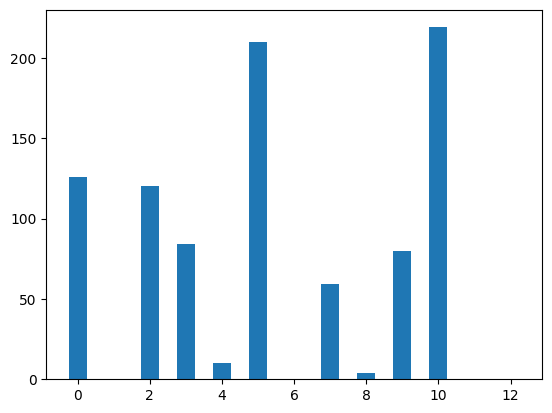

In [ ]:
import matplotlib.pyplot as plt
directory = "/content/drive/MyDrive/Colab/bach/train"

csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
file = csv_files[0]
df = pd.read_csv(file)
dm = np.array(df)
dm = np.reshape(dm,dm.shape[0]*dm.shape[1])
dm = dm - 60
dm = dm % 12
plt.hist(dm, bins=np.arange(14)-0.5, rwidth=0.5, );

In [ ]:
np.histogram(dm, bins=np.arange(13)-0.5)[0]

array([126,   0, 120,  84,  10, 210,   0,  59,   4,  80, 219,   0])

In [ ]:
def closest_major(song):
  song = np.reshape(song,song.shape[0]*song.shape[1])
  song = song - 60
  song = song % 12
  major = np.array([1,0,0,0,1,0,0,1,0,0,0,0]) / 3
  target = np.histogram(song, bins=np.arange(13)-0.5)[0]
  target = target / np.sum(target)
  result = 0
  for i in range(12):
    key = np.roll(major,i)
    dist = np.sum(np.abs(key-target))
    if dist < result or result == 0:
      result = dist
      result_key = i
  return result_key, result

In [ ]:
def closest_minor(song):
  song = np.reshape(song,song.shape[0]*song.shape[1])
  song = song - 60
  song = song % 12
  minor = np.array([1,0,0,1,0,0,0,1,0,0,0,0]) / 3
  target = np.histogram(song, bins=np.arange(13)-0.5)[0]
  target = target / np.sum(target)
  result = 0
  for i in range(12):
    key = np.roll(minor,i)
    dist = np.sum(np.abs(key-target))
    if dist < result or result == 0:
      result = dist
      result_key = i
  return result_key, result

In [ ]:
def closest_key(song):
  major_key, major_dist = closest_major(song)
  minor_key, minor_dist = closest_minor(song)
  if major_dist < minor_dist:
    return major_key
  else:
    return minor_key

In [ ]:
import matplotlib.pyplot as plt

csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
for file in csv_files:
  df = pd.read_csv(file)
  dm = np.array(df)
  print(file,closest_key(dm))


/content/drive/MyDrive/Colab/bach/train/chorale_065.csv 10
/content/drive/MyDrive/Colab/bach/train/chorale_026.csv 9
/content/drive/MyDrive/Colab/bach/train/chorale_174.csv 9
/content/drive/MyDrive/Colab/bach/train/chorale_070.csv 2
/content/drive/MyDrive/Colab/bach/train/chorale_149.csv 7
/content/drive/MyDrive/Colab/bach/train/chorale_003.csv 0
/content/drive/MyDrive/Colab/bach/train/chorale_161.csv 0
/content/drive/MyDrive/Colab/bach/train/chorale_099.csv 4
/content/drive/MyDrive/Colab/bach/train/chorale_081.csv 7
/content/drive/MyDrive/Colab/bach/train/chorale_053.csv 2
/content/drive/MyDrive/Colab/bach/train/chorale_145.csv 5
/content/drive/MyDrive/Colab/bach/train/chorale_150.csv 2
/content/drive/MyDrive/Colab/bach/train/chorale_173.csv 4
/content/drive/MyDrive/Colab/bach/train/chorale_171.csv 10
/content/drive/MyDrive/Colab/bach/train/chorale_024.csv 2
/content/drive/MyDrive/Colab/bach/train/chorale_031.csv 0
/content/drive/MyDrive/Colab/bach/train/chorale_223.csv 2
/content/dri

In [ ]:
directory = "/content/drive/MyDrive/Colab/bach/train"
DM = np.array([0,0,0,0])
csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
for file in csv_files:
  df = pd.read_csv(file)
  dm = np.array(df)
  key = closest_key(dm)
  if key>6:
    key -= 12
  dm[dm>0] -= key
  DM = np.append(DM,dm)
  DM = np.append(DM,[0,0,0,0])


shift =  (np.min(DM[DM>0])-1)
DM[DM>0] -= shift


In [ ]:
np.min(DM[DM>0]),np.max(DM)

(1, 56)

(array([ 1365.,  2922.,  6754., 24160., 31965., 50573., 52591., 35425.,
        15252.,   825.]),
 array([ 0. ,  5.6, 11.2, 16.8, 22.4, 28. , 33.6, 39.2, 44.8, 50.4, 56. ]),
 <BarContainer object of 10 artists>)

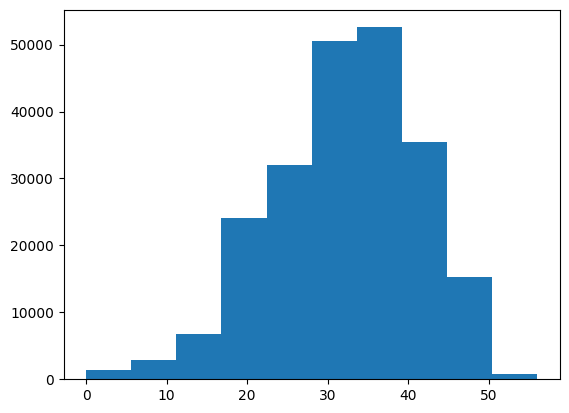

In [ ]:
plt.hist(DM)

In [ ]:
# X_unique = DM[np.insert(np.any(DM[1:] != DM[:-1], axis=1), 0, True)]
# DM = X_unique.reshape((-1,))

In [ ]:
width = 256
X = []
Y = []
for i in range(0, DM.shape[0] - width - 4, 4): # Changed loop condition to ensure enough space for y
    x = DM[i:i + width]
    y = DM[i + width:i + width + 4] # Changed y to ensure shape is always (4,)
    X.append(x)
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape[0], X.shape[1])
# Y remains with shape (num_samples, 4)

In [ ]:
X.shape, Y.shape, np.max(X) - np.min(X)

((55393, 256), (55393, 4), 56)

In [ ]:
diff = 0
for i in range(X.shape[0]):
  a = X[i,-4:]
  b = Y[i]
  if (a[0]==b[0]):
    diff += 1
print(diff/X.shape[0])

0.8022674345133861


In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = np.max(X) - np.min(X) + 1  # Assuming 38 unique classes in your target variable
Y_one_hot = []

for i in range(Y.shape[0]):
  y_i = Y[i]
  y_i_encoded = to_categorical(y_i, num_classes=num_classes)
  Y_one_hot.append(y_i_encoded)

Y_one_hot = np.array(Y_one_hot)

print(Y_one_hot.shape) # Expected output: (224, 4, 38)


(55393, 4, 57)


In [ ]:
X = X.reshape(X.shape[0],X.shape[1])
X.shape

(55393, 256)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)

In [ ]:
# prompt: write an RNN that takes input of the size (None,4,38) and outputs one vector of the size (4,38)

import tensorflow as tf
from tensorflow.keras.layers import GRU, Embedding, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers

model = Sequential([
    Embedding(input_dim = num_classes, output_dim = 64),
    Bidirectional(GRU(256, return_sequences=True, dropout=0.2)),
    Bidirectional(GRU(256, return_sequences=True, dropout=0.2)),
    Bidirectional(GRU(256, return_sequences=False, dropout=0.5)),
    Dense(num_classes, activation='softmax') ,
])

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

model.compile(loss=loss, optimizer=optimizer) # You might need to adjust loss and optimizer
# model.summary() # Print model summary for debugging


In [ ]:
X_train[0],Y_train[0]

(array([49, 41, 32, 13, 49, 41, 32, 13, 49, 41, 32, 13, 49, 41, 32, 13, 49,
        41, 32, 13, 49, 42, 33, 18, 49, 42, 33, 18, 49, 42, 33, 30, 49, 42,
        33, 30, 50, 42, 35, 28, 50, 42, 35, 28, 50, 42, 35, 26, 50, 42, 35,
        26, 52, 40, 35, 25, 52, 40, 35, 25, 52, 40, 33, 25, 52, 40, 33, 25,
        45, 42, 33, 26, 45, 42, 33, 26, 45, 40, 33, 25, 45, 40, 33, 25, 50,
        42, 33, 23, 50, 42, 33, 23, 50, 47, 32, 23, 50, 47, 32, 23, 49, 40,
        33, 25, 49, 40, 33, 25, 49, 40, 33, 26, 49, 40, 33, 26, 47, 40, 33,
        28, 47, 40, 33, 28, 47, 40, 32, 16, 47, 38, 32, 16, 45, 37, 28, 21,
        45, 37, 28, 21, 45, 37, 28, 21, 45, 37, 28, 21, 47, 40, 32, 28, 47,
        40, 32, 28, 47, 42, 35, 26, 47, 42, 35, 26, 47, 44, 40, 25, 47, 44,
        40, 25, 47, 44, 38, 23, 47, 44, 38, 23, 49, 44, 37, 21, 49, 44, 37,
        21, 49, 41, 37, 23, 49, 41, 37, 23, 42, 42, 37, 21, 42, 42, 37, 21,
        42, 40, 35, 20, 42, 40, 35, 20, 47, 38, 33, 18, 47, 38, 33, 18, 47,
        37, 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input
input_layer = Input(shape=(None,))

# Embedding Layer (adjust input_dim if necessary)
x = Embedding(input_dim=num_classes + 1, output_dim=1000, mask_zero=False)(input_layer)

# Recurrent Layers
x = LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
x = LSTM(256, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(x)
# x = Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
# x = Bidirectional(GRU(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4))(x)

# Intermediate Dense Layer
x = Dense(128, activation='relu')(x)
x = LayerNormalization()(x)  # Normalization for stability

# Output Layers
outputS = Dense(num_classes, activation='softmax', name="outputS")(x)
outputA = Dense(num_classes, activation='softmax', name="outputA")(x)
outputT = Dense(num_classes, activation='softmax', name="outputT")(x)
outputB = Dense(num_classes, activation='softmax', name="outputB")(x)

# Define Model
model = Model(input_layer, [outputS, outputA, outputT, outputB], name="Bach")

# Compile Model with Custom Loss Weights
model.compile(optimizer=Adam(learning_rate=0.01),
              loss={"outputS": "categorical_crossentropy",
                    "outputA": "categorical_crossentropy",
                    "outputT": "categorical_crossentropy",
                    "outputB": "categorical_crossentropy"},
              loss_weights={"outputS": 1.0, "outputA": 1.0, "outputT": 1.0, "outputB": 1.0},
              metrics=['accuracy','accuracy','accuracy','accuracy'])

model.summary()


Model: "Bach"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 1000)     │         58,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, None, 256)      │      1,287,168 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128)            │            256 │ dense_1[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputS (Dense)           │ (None, 57)             │          7,353 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputA (Dense)           │ (None, 57)             │          7,353 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputT (Dense)           │ (None, 57)             │          7,353 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputB (Dense)           │ (None, 57)             │          7,353 │ layer_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,933,044 (7.37 MB)

 Trainable params: 1,933,044 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Reshape Y_one_hot to match the model's output structure
Y_train_list = [Y_train[:, i, :] for i in range(4)]  # Split into 4 arrays
Y_test_list = [Y_test[:, i, :] for i in range(4)]    # Split into 4 arrays

# Fit the model with the reshaped target data
model.fit(X_train, Y_train_list, epochs=1, verbose=1, validation_split=0.1, batch_size=1024)

39/39 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - loss: 12.2256 - outputA_accuracy: 0.2124 - outputA_loss: 2.9915 - outputB_accuracy: 0.1455 - outputB_loss: 3.2068 - outputS_accuracy: 0.1616 - outputS_loss: 3.0106 - outputT_accuracy: 0.1755 - outputT_loss: 3.0165 - val_loss: 7.5174 - val_outputA_accuracy: 0.4648 - val_outputA_loss: 1.6515 - val_outputB_accuracy: 0.3245 - val_outputB_loss: 2.2055 - val_outputS_accuracy: 0.3145 - val_outputS_loss: 1.8735 - val_outputT_accuracy: 0.4032 - val_outputT_loss: 1.8111


In [ ]:
model.fit(X_train, Y_train_list, epochs=3, verbose=1, validation_split=0.1, batch_size=1024,
          callbacks=[early_stopping_callback])

Epoch 1/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 4.0945 - outputA_accuracy: 0.7324 - outputA_loss: 0.9873 - outputB_accuracy: 0.7087 - outputB_loss: 1.1638 - outputS_accuracy: 0.7520 - outputS_loss: 0.9132 - outputT_accuracy: 0.7266 - outputT_loss: 1.0302 - val_loss: 3.8768 - val_outputA_accuracy: 0.7455 - val_outputA_loss: 0.9218 - val_outputB_accuracy: 0.7191 - val_outputB_loss: 1.1014 - val_outputS_accuracy: 0.7615 - val_outputS_loss: 0.8773 - val_outputT_accuracy: 0.7466 - val_outputT_loss: 0.9770
Epoch 2/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 3.8956 - outputA_accuracy: 0.7467 - outputA_loss: 0.9270 - outputB_accuracy: 0.7117 - outputB_loss: 1.1207 - outputS_accuracy: 0.7566 - outputS_loss: 0.8739 - outputT_accuracy: 0.7416 - outputT_loss: 0.9740 - val_loss: 3.7695 - val_outputA_accuracy: 0.7561 - val_outputA_loss: 0.8853 - val_outputB_accuracy: 0.7229 - val_outputB_loss: 1.0674 - val_outputS_accuracy: 0.7746 - val_outputS_loss: 0.8650 - val_outputT_accuracy: 0.75

In [ ]:
# prompt: select a random X and call model.predict. convert the result from one_hot_encoded back to ordinal. compare the prediction to the actual Y value

import random

# Select a random index
random_index = random.randint(0, len(X_test) - 1)

# Get the input and target
x_sample = X_test[random_index:random_index+1]
y_actual = np.argmax(Y_test[random_index],axis=1)

# Make prediction
prediction_one_hot = np.array(model.predict(x_sample))
print(prediction_one_hot.shape)
# Convert one-hot encoded prediction back to ordinal
prediction = np.argmax(prediction_one_hot,axis=2).reshape(-1,)

print("x_sample:", x_sample)
print("Actual Y value:", y_actual)
print("Predicted Y value:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
(4, 1, 57)
x_sample: [[42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18
  42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 18
  42 37 34 18 42 37 34 18 42 37 34 18 42 37 34 22 42 37 34 22 42 37 34 22
  42 37 34 22 44 37 29 25 44 37 29 25 44 37 29 25 44 37 29 25 46 37 30 30
  46 37 30 30 46 37 30 30 46 37 30 30 46 37 30 30 46 37 30 30 46 37 30 30
  46 37 30 30 44 37 32 29 44 37 32 29 44 37 32 29 44 37 32 29 42 39 32 24
  42 39 32 24 42 39 32 24 42 39 32 24 41 37 32 25 41 37 32 25 41 37 32 25
  41 37 32 25 39 36 32 20 39 36 32 20 39 36 32 20 39 36 32 20 37 32 29 25
  37 32 29 25 37 32 29 25 37 32 29 25 37 32 29 25 37 32 29 25 37 32 29 25
  37 32 29 25 37 32 29 25 37 32 29 25 37 32 29 25 37 32 29 25 42 39 34 27
  42 39 34 27 42 39 34 27 42 39 34 27 42 39 34 27]]
Actual Y value: [42 39 34 27]
Predicted Y value: [42 39 34 27]


In [ ]:
def get_next(input_sequence, temperature=1):
  prediction_one_hot = np.array(model.predict(input_sequence, verbose = 0))
  # Reshape to (batch_size, num_classes) before applying log and softmax
  # prediction_one_hot has shape (4, 1, 57), so we need to reshape to (4,57) for each prediction
  reshaped_prediction_one_hot = prediction_one_hot.reshape(prediction_one_hot.shape[0], -1)
  reshaped_prediction_one_hot = np.log(reshaped_prediction_one_hot) / temperature

  # Apply tf.random.categorical to each reshaped prediction
  predictions = []
  for i in range(reshaped_prediction_one_hot.shape[0]):
    prediction = tf.random.categorical(reshaped_prediction_one_hot[i:i+1], num_samples=1)
    predictions.append(prediction)

  # Stack the predictions back into a single tensor
  final_prediction = np.array(predictions).reshape(4,)

  return final_prediction

In [ ]:
def get_several(input_sequence, num, temperature=1):
  result = input_sequence
  for i in range(num):
    print(".", end='')
    next = get_next(input_sequence, temperature)
    input_sequence = np.hstack([input_sequence,[next]])
    input_sequence = input_sequence[:,4:]
    result = np.hstack([result,[next]])
  return result.reshape(-1,4)

In [ ]:
get_next(X_train[10:11],temperature=0.01)


array([44, 44, 37, 35])

In [ ]:
# prompt: find all rows in X_test that start with 0,0,0,0

import numpy as np

# Assuming X_test is defined as in your provided code
# Find rows in X_test that start with [0, 0, 0, 0]
rows_starting_with_zeros = []
for i in range(len(X_test)):
    if np.array_equal(X_test[i][:4], [0, 0, 0, 0]):
        rows_starting_with_zeros.append(X_test[i])

print(f"Number of rows in X_test starting with [0, 0, 0, 0]: {len(rows_starting_with_zeros)}")

# If you want to print the rows themselves
# for row in rows_starting_with_zeros:
#     print(row)


Number of rows in X_test starting with [0, 0, 0, 0]: 52


In [ ]:
input = rows_starting_with_zeros[random.randrange(0,51)].reshape(1,-1)
song = get_several(input,128,temperature=1)


................................................................................................................................

In [ ]:
id+=1
quartet_to_midi(song+shift, f"chorale-{id}.mid")

Saved MIDI file to chorale-12.mid


<ipython-input-60-0b81e801bc39>:14: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll,


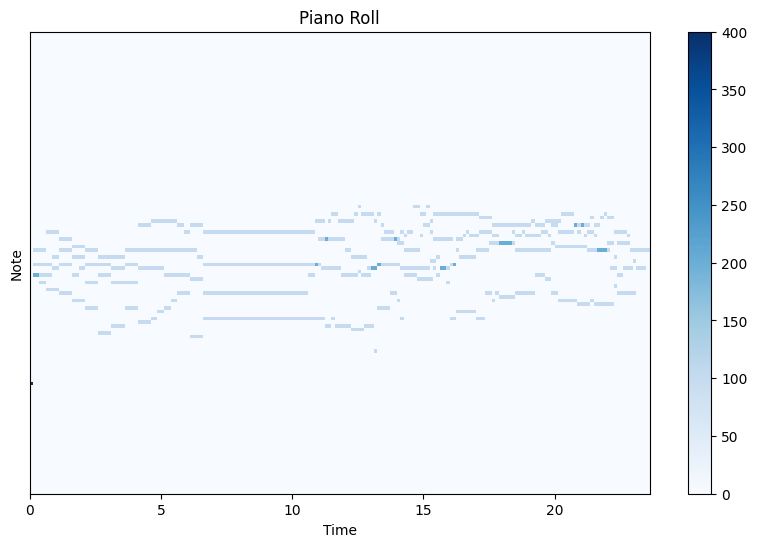

In [ ]:
os.system(f"fluidsynth -ni font.sf2 chorale-{id}.mid -F chorale-{id}.wav -r 44100")
display_piano_roll(f"chorale-{id}.mid")
Audio(f'chorale-{id}.wav')

<ipython-input-60-0b81e801bc39>:14: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll,


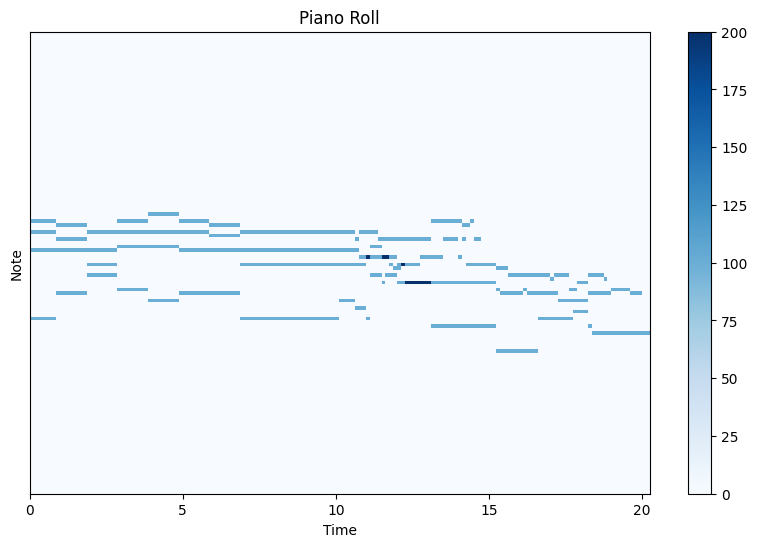

In [ ]:
# prompt: display  a piano roll represenatation of the midi file

import pretty_midi
import matplotlib.pyplot as plt
import librosa

def display_piano_roll(midi_file_path):
    """Displays a piano roll representation of a MIDI file."""
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file_path)
        piano_roll = midi_data.get_piano_roll(fs=100)  # Adjust fs for resolution

        plt.figure(figsize=(10, 6))
        librosa.display.specshow(piano_roll,
                                 hop_length=1,
                                 sr=100,
                                 x_axis='time',
                                 y_axis='cqt_note',
                                 cmap='Blues')
        plt.colorbar()
        plt.title('Piano Roll')
        plt.show()

    except Exception as e:
        print(f"Error processing MIDI file: {e}")

# Example usage (replace with your MIDI file path)
midi_file_path = "chorale-6.mid"  # Assuming you have generated a chorale-1.mid
display_piano_roll(midi_file_path)
